<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [97]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [98]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Pytorch version: {torch.__version__}")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("No GPU available.")

Pytorch version: 2.0.1+cu118
Device name: Tesla T4


In [99]:
# torchsummar actualmente tiene un problema con las LSTM, por eso
# se utiliza torchinfo, un fork del proyecto original con el bug solucionado
!pip3 install torchinfo
from torchinfo import summary

In [100]:
import os
import platform

if os.access('torch_helpers.py', os.F_OK) is False:
    if platform.system() == 'Windows':
        !curl !wget https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py > torch_helpers.py
    else:
        !wget torch_helpers.py https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py

In [101]:
from torch_helpers import categorical_acc

def train(model, train_loader, valid_loader, optimizer, criterion, epochs=100):
    # Defino listas para realizar graficas de los resultados
    train_loss = []
    train_accuracy = []
    valid_loss = []
    valid_accuracy = []

    # Defino mi loop de entrenamiento

    for epoch in range(epochs):

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:
            # Seteo los gradientes en cero ya que, por defecto, PyTorch
            # los va acumulando
            optimizer.zero_grad()

            output = model(train_data)

            # Computo el error de la salida comparando contra las etiquetas
            loss = criterion(output, train_target)

            # Almaceno el error del batch para luego tener el error promedio de la epoca
            epoch_train_loss += loss.item()

            # Computo el nuevo set de gradientes a lo largo de toda la red
            loss.backward()

            # Realizo el paso de optimizacion actualizando los parametros de toda la red
            optimizer.step()

            # Calculo el accuracy del batch
            accuracy = categorical_acc(output, train_target)
            # Almaceno el accuracy del batch para luego tener el accuracy promedio de la epoca
            epoch_train_accuracy += accuracy.item()

        # Calculo la media de error para la epoca de entrenamiento.
        # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
        epoch_train_loss = epoch_train_loss / len(train_loader)
        train_loss.append(epoch_train_loss)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_accuracy.append(epoch_train_accuracy)

        # Realizo el paso de validación computando error y accuracy, y
        # almacenando los valores para imprimirlos y graficarlos
        valid_data, valid_target = next(iter(valid_loader))
        output = model(valid_data)

        epoch_valid_loss = criterion(output, valid_target).item()
        valid_loss.append(epoch_valid_loss)

        # Calculo el accuracy de la epoch
        epoch_valid_accuracy = categorical_acc(output, valid_target).item()
        valid_accuracy.append(epoch_valid_accuracy)

        print(f"Epoch: {epoch+1}/{epochs} - Train loss {epoch_train_loss:.3f} - Train accuracy {epoch_train_accuracy:.3f} - Valid Loss {epoch_valid_loss:.3f} - Valid accuracy {epoch_valid_accuracy:.3f}")

    history = {
        "loss": train_loss,
        "accuracy": train_accuracy,
        "val_loss": valid_loss,
        "val_accuracy": valid_accuracy,
    }
    return history

### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

In [102]:
# Descargar la carpeta de dataset
import os
import platform
if os.access('./songs_dataset', os.F_OK) is False:
    if os.access('songs_dataset.zip', os.F_OK) is False:
        if platform.system() == 'Windows':
            !curl https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip -o songs_dataset.zip
        else:
            !wget songs_dataset.zip https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
    !unzip -q songs_dataset.zip
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [103]:
# Posibles bandas
os.listdir("./songs_dataset/")

['beatles.txt',
 'dj-khaled.txt',
 'michael-jackson.txt',
 'kanye.txt',
 'nirvana.txt',
 'dr-seuss.txt',
 'al-green.txt',
 'alicia-keys.txt',
 'kanye-west.txt',
 'r-kelly.txt',
 'lorde.txt',
 'britney-spears.txt',
 'janisjoplin.txt',
 'notorious-big.txt',
 'adele.txt',
 'leonard-cohen.txt',
 'bob-marley.txt',
 'cake.txt',
 'lil-wayne.txt',
 'joni-mitchell.txt',
 'disney.txt',
 'dickinson.txt',
 'ludacris.txt',
 'lady-gaga.txt',
 'jimi-hendrix.txt',
 'rihanna.txt',
 'nursery_rhymes.txt',
 'bob-dylan.txt',
 'blink-182.txt',
 'missy-elliott.txt',
 'nicki-minaj.txt',
 'drake.txt',
 'paul-simon.txt',
 'bruno-mars.txt',
 'dolly-parton.txt',
 'notorious_big.txt',
 'Lil_Wayne.txt',
 'patti-smith.txt',
 'bieber.txt',
 'bruce-springsteen.txt',
 'radiohead.txt',
 'amy-winehouse.txt',
 'lin-manuel-miranda.txt',
 'nickelback.txt',
 'bjork.txt',
 'johnny-cash.txt',
 'Kanye_West.txt',
 'eminem.txt',
 'prince.txt']

In [104]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
# Inicializa la variable df como una lista vacía
df = list()

# Lista de nombres de archivos .txt que deseas concatenar
archivos = ['songs_dataset/bruce-springsteen.txt',
            'songs_dataset/rihanna.txt',
            'songs_dataset/eminem.txt',
            'songs_dataset/michael-jackson.txt']

# Itera a través de los archivos y concaténalos en df
for archivo in archivos:
  # Armar el dataset utilizando salto de línea para separar las oraciones/docs
  df_aux = pd.read_csv(archivo, sep='/n', header=None)
  # Agrega df_aux a df
  df.append(df_aux)

df = pd.concat(df, ignore_index=True)
df.head()

<ipython-input-104-77ffebf9e1f5>:14: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_aux = pd.read_csv(archivo, sep='/n', header=None)
<ipython-input-104-77ffebf9e1f5>:14: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_aux = pd.read_csv(archivo, sep='/n', header=None)
<ipython-input-104-77ffebf9e1f5>:14: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_aux = pd.read_csv(archivo, sep='/n', header=None)
<ipytho

,0
0,[Verse 1]
1,They come from everywhere
2,A longing to be free
3,They come to join us here
4,From sea to shining sea And they all have a dream


In [105]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 22604


### 1 - Ejemplo de Preprocesamiento
- Hay que transformar las oraciones en tokens.
- Dichas oraciones hay que ajustarlas al tamaño fijo de nuestra sentencia de entrada al modelo.
- Hay que separar las palabras objetivos (target) que el modelo debe predecir en cada sentencia armada.

In [ ]:
from torch_helpers import Tokenizer # tool de keras equivalente a ltokenizer de nltk
from torch_helpers import text_to_word_sequence # tool de keras equivalente a word_teokenize de nltk
from torch_helpers import pad_sequences # tool de keras qye se utilizará para padding

# largo de la secuencia, incluye seq input + word output
train_len = 4

In [ ]:
# Ejemplo de como transformar una oración a tokens usando keras
text = df.loc[0,0]
text

'[Verse 1]'

In [ ]:
tokens = text_to_word_sequence(text) # entran oraciones -> salen vectores de N posiciones (tokens)
tokens

['verse', '1']

1.1 - Transformar las oraciones en secuencias (tokens) de palabras

In [ ]:
# Recorrer todas las filas y transformar las oraciones
# en secuencias de palabras
sentence_tokens = []
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [ ]:
# Demos un vistazo
sentence_tokens[:2]

[['verse', '1'], ['they', 'come', 'from', 'everywhere']]

In [ ]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []

for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [ ]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
# seq_input + output
text_sequences

[]

1.2 - Crear los vectores de palabras (word2vec)

Ahora necesitamos pasarlos a números para que lo entienda la red y separar input de output.
- El Input seran integers (word2vec)
- Mientras que el output será one hot encodeado (labels) del tamaño del vocabulario

In [ ]:
tok = Tokenizer()

# El tokeinzer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
tok.fit_on_texts(text_sequences)

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

In [ ]:
# Ahora sequences tiene los números "ID", largo 4
sequences

[]

In [ ]:
# Cantidad de casos (doc) de entrada
print(tok.document_count)

0


In [ ]:
# Cantidad de palabras distintas
print(len(tok.word_counts))

0


In [ ]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{}


In [ ]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {})


### 2 - Preprocesamiento completo
Debemos realizar los mismos pasos que en el ejemplo anterior, pero antes de eso debemos transformar ese dataset de filas de oraciones en un texto completo continuo para poder extraer el vocabulario.

In [ ]:
# Vistazo a las primeras filas
df.loc[:15,0]

0                                             [Verse 1]
1                             They come from everywhere
2                                  A longing to be free
3                             They come to join us here
4     From sea to shining sea And they all have a dream
5                                 As people always will
6                                   To be safe and warm
7     In that shining city on the hill Some wanna sl...
8                           Instead of opening the gate
9                      Aw, let's turn this thing around
10                     Before it gets too late [Chorus]
11                                It's up to me and you
12                                Love can conquer hate
13                               I know this to be true
14                 That's what makes us great [Verse 2]
15                                  Don't tell me a lie
Name: 0, dtype: object

In [ ]:
# Concatenamos todos los rows en un solo valor
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
corpus

'[Verse 1] They come from everywhere A longing to be free They come to join us here From sea to shining sea And they all have a dream As people always will To be safe and warm In that shining city on the hill Some wanna slam the door Instead of opening the gate Aw, let\'s turn this thing around Before it gets too late [Chorus] It\'s up to me and you Love can conquer hate I know this to be true That\'s what makes us great [Verse 2] Don\'t tell me a lie And sell it as a fact I\'ve been down that road before And I ain\'t goin\' back And don\'t you brag to me That you never read a book I never put my faith In a con man and his crooks I won\'t follow down that path And tempt the hands of fate Aw, let\'s turn this thing around Before it gets too late [Chorus] It\'s up to me and you Love can conquer hate I know this to be true That\'s what makes us great In the quiet of the night I lie here wide awake And I ask myself Is there a difference I can make? [Chorus] It\'s up to me and you Love can 

In [ ]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:20]

['verse',
 '1',
 'they',
 'come',
 'from',
 'everywhere',
 'a',
 'longing',
 'to',
 'be',
 'free',
 'they',
 'come',
 'to',
 'join',
 'us',
 'here',
 'from',
 'sea',
 'to']

In [ ]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 21566


In [ ]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [ ]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:20]

[['verse', '1', 'they', 'come'],
 ['1', 'they', 'come', 'from'],
 ['they', 'come', 'from', 'everywhere'],
 ['come', 'from', 'everywhere', 'a'],
 ['from', 'everywhere', 'a', 'longing'],
 ['everywhere', 'a', 'longing', 'to'],
 ['a', 'longing', 'to', 'be'],
 ['longing', 'to', 'be', 'free'],
 ['to', 'be', 'free', 'they'],
 ['be', 'free', 'they', 'come'],
 ['free', 'they', 'come', 'to'],
 ['they', 'come', 'to', 'join'],
 ['come', 'to', 'join', 'us'],
 ['to', 'join', 'us', 'here'],
 ['join', 'us', 'here', 'from'],
 ['us', 'here', 'from', 'sea'],
 ['here', 'from', 'sea', 'to'],
 ['from', 'sea', 'to', 'shining'],
 ['sea', 'to', 'shining', 'sea'],
 ['to', 'shining', 'sea', 'and']]

In [ ]:
# Proceso de tokenizacion
tok = Tokenizer()
tok.fit_on_texts(text_sequences)

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[738, 1330, 40, 34],
 [1330, 40, 34, 64],
 [40, 34, 64, 739],
 [34, 64, 739, 3],
 [64, 739, 3, 610],
 [739, 3, 610, 7],
 [3, 610, 7, 35],
 [610, 7, 35, 224],
 [7, 35, 224, 40],
 [35, 224, 40, 34],
 [224, 40, 34, 7],
 [40, 34, 7, 960],
 [34, 7, 960, 123],
 [7, 960, 123, 53],
 [960, 123, 53, 64],
 [123, 53, 64, 410],
 [53, 64, 410, 7],
 [64, 410, 7, 303],
 [410, 7, 303, 410],
 [7, 303, 410, 4]]

In [ ]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 21562


### 3 - Input y target

In [ ]:
# Con numpy es muy fácil realizar el slicing de vectores
ex = np.array([[1,2,3,4],[5,6,7,8]])
ex

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

In [ ]:
# Con numpy es muy fácil realizar el slicing de vectores
print("Dimension:", ex.shape)
print("Todos los elementos:", ex)
print("Todos los elementos menos el último:", ex[:, :-1])

Dimension: (2, 4)
Todos los elementos: [[1 2 3 4]
 [5 6 7 8]]
Todos los elementos menos el último: [[1 2 3]
 [5 6 7]]


In [ ]:
input = ex[:,:-1] # todos los rows, menos la ultima col
target = ex[:, -1] # última col de cada row

print("Input:", input)
print("Target:", target)

Input: [[1 2 3]
 [5 6 7]]
Target: [4 8]


In [ ]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(21562, 3)
(21562,)


In [ ]:
# Palabras del vocabulario
tok.index_word

{1: 'the',
 2: 'i',
 3: 'a',
 4: 'and',
 5: 'you',
 6: 'in',
 7: 'to',
 8: 'me',
 9: 'my',
 10: 'on',
 11: 'your',
 12: 'of',
 13: 'that',
 14: "don't",
 15: 'all',
 16: 'love',
 17: 'down',
 18: 'but',
 19: 'it',
 20: 'night',
 21: 'well',
 22: 'for',
 23: 'oh',
 24: 'just',
 25: 'out',
 26: "i'm",
 27: 'this',
 28: 'with',
 29: 'got',
 30: 'baby',
 31: 'was',
 32: 'we',
 33: 'up',
 34: 'come',
 35: 'be',
 36: 'no',
 37: 'know',
 38: 'like',
 39: 'la',
 40: 'they',
 41: 'back',
 42: 'now',
 43: 'one',
 44: "ain't",
 45: 'when',
 46: 'there',
 47: 'is',
 48: 'if',
 49: 'so',
 50: 'what',
 51: 'little',
 52: 'want',
 53: 'here',
 54: 'her',
 55: 'yeah',
 56: 'tonight',
 57: 'at',
 58: 'can',
 59: 'let',
 60: "it's",
 61: 'girl',
 62: "i'll",
 63: 'go',
 64: 'from',
 65: 'do',
 66: 'he',
 67: 'she',
 68: 'man',
 69: 'pay',
 70: 'li',
 71: "there's",
 72: 'as',
 73: 'will',
 74: 'some',
 75: 'his',
 76: 'hey',
 77: 'heart',
 78: 'by',
 79: 'say',
 80: 'are',
 81: 'get',
 82: "you're",
 83

In [ ]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

2538

In [ ]:
# ¡Ojo! y_data_int comienza en "1" en vez de "0"
# valor minimo:
min(y_data_int)

1

In [ ]:
# Hay que restar 1
y_data_int_offset = y_data_int - 1
min(y_data_int_offset)

0

In [ ]:
class Data(Dataset):
    def __init__(self, x, y):
        # Convertir los arrays de numpy a tensores.
        # pytorch espera en general entradas 32bits
        self.x = torch.from_numpy(x.astype(np.int32))
        # Transformar los datos a oneHotEncoding
        # la loss function esperan la salida float
        self.y = F.one_hot(torch.from_numpy(y), num_classes=vocab_size).float()

        self.len = self.y.shape[0]

    def __getitem__(self,index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.len

data_set = Data(x_data, y_data_int_offset)

input_size = data_set.x.shape[1]
print("input_size:", input_size)

output_dim = data_set.y.shape[1]
print("Output dim", output_dim)

input_size: 3
Output dim 2538


In [ ]:
torch.manual_seed(402)
valid_set_size = int(data_set.len * 0.2)
train_set_size = data_set.len - valid_set_size

train_set = torch.utils.data.Subset(data_set, range(train_set_size))
valid_set = torch.utils.data.Subset(data_set, range(train_set_size, data_set.len))

print("Tamaño del conjunto de entrenamiento:", len(train_set))
print("Tamaño del conjunto de validacion:", len(valid_set))

train_batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=train_batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=len(valid_set), shuffle=False)

Tamaño del conjunto de entrenamiento: 17250
Tamaño del conjunto de validacion: 4312


### 4 - Entrenar el modelo

In [ ]:
class Model1(nn.Module):
    def __init__(self, vocab_size, output_dim):
        super().__init__()
        # num_embeddings = vocab_size --> 1628 palabras distintas + 1 para padding o UNK
        # embedding_dim = 5 --> crear embeddings de tamaño 5 (tamaño variable y ajustable)
        self.lstm_size = 64
        self.num_layers = 3
        self.embedding = nn.Embedding(num_embeddings=vocab_size+1, embedding_dim=5, padding_idx=0)
        self.lstm1 = nn.LSTM(input_size=5, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers, dropout=0.4) # LSTM layer
        self.fc1 = nn.Linear(in_features=self.lstm_size, out_features=32) # Fully connected layer
        self.fc2 = nn.Linear(in_features=32, out_features=output_dim) # Fully connected layer

        self.relu = nn.LeakyReLU(0.1)
        self.softmax = nn.Softmax(dim=1) # normalize in dim 1

    def forward(self, x, prev_state=None):
        if prev_state is None:
            # En cada nueva inferencia reinicio el hidden state
            # de la LSTM al menos que sea pasado por parámetro el
            # elstado de previo
            # Esta acción se realiza especialmente para que
            # el hidden_state de la última inferencia no afecte
            # a la siguiente
            batch_size = x.shape[0] #(batch, seq_size)
            prev_state = self.init_hidden(batch_size)

        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm1(out, prev_state)
        out = self.relu(self.fc1(lstm_output[:,-1,:])) # take last output (last seq)
        out = self.softmax(self.fc2(out))
        return out


    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.lstm_size),
                torch.zeros(self.num_layers, batch_size, self.lstm_size))

model1 = Model1(vocab_size=vocab_size, output_dim=output_dim)

# Crear el optimizador la una función de error
model1_optimizer = torch.optim.Adam(model1.parameters(), lr=0.01)
model1_criterion = torch.nn.CrossEntropyLoss()  # Para clasificación multi categórica

# Por defecto torchinfo testea el modelo con torch.FloatTensor
summary(model1, input_size=(1, input_size), dtypes=['torch.IntTensor'], device=torch.device('cpu'))

# otra posibilidad
#summary(model1, input_data=data_set[0][0].unsqueeze(0))

Layer (type:depth-idx)                   Output Shape              Param #
Model1                                   [1, 2538]                 --
├─Embedding: 1-1                         [1, 3, 5]                 12,695
├─LSTM: 1-2                              [1, 3, 64]                84,736
├─Linear: 1-3                            [1, 32]                   2,080
├─LeakyReLU: 1-4                         [1, 32]                   --
├─Linear: 1-5                            [1, 2538]                 83,754
├─Softmax: 1-6                           [1, 2538]                 --
Total params: 183,265
Trainable params: 183,265
Non-trainable params: 0
Total mult-adds (M): 0.35
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.73
Estimated Total Size (MB): 0.76

In [ ]:
history1 = train(model1,
                train_loader,
                valid_loader,
                model1_optimizer,
                model1_criterion,
                epochs=10
                )

Epoch: 1/10 - Train loss 7.814 - Train accuracy 0.027 - Valid Loss 7.817 - Valid accuracy 0.023
Epoch: 2/10 - Train loss 7.813 - Train accuracy 0.027 - Valid Loss 7.817 - Valid accuracy 0.023
Epoch: 3/10 - Train loss 7.813 - Train accuracy 0.027 - Valid Loss 7.817 - Valid accuracy 0.023
Epoch: 4/10 - Train loss 7.813 - Train accuracy 0.027 - Valid Loss 7.817 - Valid accuracy 0.023
Epoch: 5/10 - Train loss 7.813 - Train accuracy 0.027 - Valid Loss 7.817 - Valid accuracy 0.023
Epoch: 6/10 - Train loss 7.813 - Train accuracy 0.027 - Valid Loss 7.817 - Valid accuracy 0.023
Epoch: 7/10 - Train loss 7.813 - Train accuracy 0.027 - Valid Loss 7.817 - Valid accuracy 0.023
Epoch: 8/10 - Train loss 7.813 - Train accuracy 0.027 - Valid Loss 7.817 - Valid accuracy 0.023
Epoch: 9/10 - Train loss 7.813 - Train accuracy 0.027 - Valid Loss 7.817 - Valid accuracy 0.023
Epoch: 10/10 - Train loss 7.813 - Train accuracy 0.027 - Valid Loss 7.817 - Valid accuracy 0.023


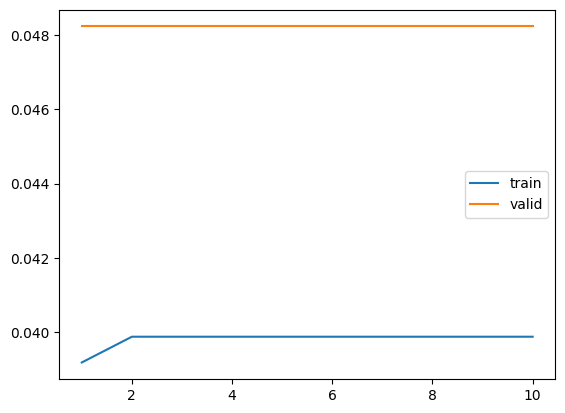

In [ ]:
epoch_count = range(1, len(history1['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history1['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history1['val_accuracy'], label='valid')
plt.show()

__Es importante__ destacar que en este ejemplo estamos entrenando nuestro propios Embeddings y para ello se requiere mucha data. En los ejemplos que realizaremos de aquí en más utilizaremos más datos, embeddings pre-enternados o modelos pre-entrenados.

### 5 - Predicción de próxima palabra

In [ ]:
# pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [ ]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
import sys
!{sys.executable} -m pip install gradio --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.2/20.2 MB 63.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.4/298.4 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 9.1 MB/s eta 0:

In [ ]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')

    # Transformo a tensor
    tensor = torch.from_numpy(encoded.astype(np.int32))

    # Predicción softmax
    y_hat = model1(tensor).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

<ipython-input-232-dd4e141a6962>:27: GradioDeprecationWarning: `layout` parameter is deprecated, and it has no effect
  iface = gr.Interface(


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://a51ecb1622699866ed.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://a51ecb1622699866ed.gradio.live


### 6 - Generación de secuencias nuevas

In [ ]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

        # Transformo a tensor
        tensor = torch.from_numpy(encoded.astype(np.int32))

        # Predicción softmax
        y_hat = model1(tensor).argmax(axis=-1)

		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [ ]:
input_text='hey jude don\'t'

generate_seq(model1, tok, input_text, max_length=3, n_words=2)

"hey jude don't  "

### 7 - Conclusiones
El modelo entrenado tuvo un muy mail desempeño en el entrenamiento además de overfitting. Cuestiones que podrían mejorarse:
- Agregar más capas o neuronaes
- Incrementar la cantidad de épocas
- Agregar BRNN

Es importante destacar que en este ejemplo estamos entrenando nuestro propios Embeddings, y para ello se requiere mucha data. En los ejemplos que realizaremos de aquí en más utilizaremos más datos, embeddings pre-enternados o modelos pre-entrenados.